In [1]:
    THIS WAS ERROR. SENTENCE IS SINGLE LETTERS INSTEAD OF WORDS
    THIS WAS ERROR. SENTENCE IS SINGLE LETTERS INSTEAD OF WORDS
    THIS WAS ERROR. SENTENCE IS SINGLE LETTERS INSTEAD OF WORDS
    THIS WAS ERROR. SENTENCE IS SINGLE LETTERS INSTEAD OF WORDS

SyntaxError: invalid syntax (<ipython-input-1-6288e39d62f2>, line 1)

In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'whole_gen_11_fixes'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [34]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [35]:
sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
sample_data = sample_data[sample_data['class'] != 'MANUAL']
sample_data = sample_data[sample_data['class'] != 'ELECTRONIC']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 649369,  (dropped rows: 9268823)


In [36]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['LETTERS', 'NUMBERS', 'PLAIN', 'VERBATIM']
4


### Utils stuff

In [37]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [38]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [39]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [40]:
sos_tensor = torch.zeros(1, 1, len(words_after_index))
sos_tensor[0, 0, words_after_index[SOS_TOKEN]] = 1
sos_tensor.size()
#del(onehot_sos)

# sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

torch.Size([1, 1, 1351])

### More balanced sample

In [41]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_randomize_freq = False
balanced_data_length = 0

def balanced_data_randomize_org(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.2
    balanced_data_accessed_counter = 0
balanced_data_randomize = balanced_data_randomize_org

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_randomize_freq and balanced_data_accessed_counter > balanced_data_randomize_freq:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [42]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
LETTERS     20000
NUMBERS     20000
PLAIN       20000
VERBATIM    11741
Name: class, dtype: int64

In [43]:
balanced_data_sample_row()

sentence_id                                               301006
token_id                                                       6
class                                                      PLAIN
before                                                  baptised
after                                                   baptized
class_org                                                  PLAIN
a_word_ind                                              [418, 0]
sentence       as george wished , she was <SAMPLE> before the...
Name: 259802, dtype: object

### Samples

In [44]:
def get_random_sample():
    sample_row = balanced_data_sample_row()   
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

LETTERS : HK -> h k <EOS> [45, 59, 0]
jarrahy r , shahinian <SAMPLE> : surgical management of pituitary tumors .
torch.Size([1, 3, 104])


In [45]:
%%timeit
get_random_sample()

159 µs ± 4.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [46]:
use_cuda = True

In [59]:
MAX_ATTENTION_LENGTH = 30

In [60]:
tmp = sample_data[sample_data['before'].str.len()>MAX_ATTENTION_LENGTH]
len(tmp)
tmp.sample(2)
tmp[~tmp['before'].str.contains('/')].sample(2)

15

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
251131,290739,9,NUMBERS,21 80 38 30 31 38 30 32 33 30 30,two one sil eight o sil three eight sil three ...,TELEPHONE,"[5, 9, 58, 16, 25, 58, 13, 16, 58, 13, 25, 58,...",0010 a 9 83 85 6 c 0 c <SAMPLE> .
500384,577146,7,NUMBERS,0-333-73432-7 ISBN 1-56159-228-5,o sil three three three sil seven three four t...,TELEPHONE,"[25, 58, 13, 13, 13, 58, 18, 13, 19, 13, 5, 58...","london : macmillan publishers , inc isbn <SAMP..."


,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
251131,290739,9,NUMBERS,21 80 38 30 31 38 30 32 33 30 30,two one sil eight o sil three eight sil three ...,TELEPHONE,"[5, 9, 58, 16, 25, 58, 13, 16, 58, 13, 25, 58,...",0010 a 9 83 85 6 c 0 c <SAMPLE> .
271272,314363,1,NUMBERS,981-232-423-2 ISBN 978-9812324238,nine eight one sil two three two sil four two ...,TELEPHONE,"[15, 16, 9, 58, 5, 13, 5, 58, 19, 5, 13, 58, 5...","isbn <SAMPLE> abdulgani , ruslan ."


### Encoder

In [61]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)
                
        output = torch.cat((output_words[0], output_chars[0]), 0)

        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, hidden_states_cat

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=256, chars_hidden_size=384,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): LSTM(50, 128, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(104, 192, batch_first=True, bidirectional=True)
)

In [62]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(encoder_output, encoder_outputs), tmp = test_encoder_single_sample()
tmp
encoder_output.size()
encoder_outputs.size()
torch.eq(encoder_output, encoder_outputs[len(tmp)]).data.all()

42


'42'

torch.Size([640])

torch.Size([30, 640])

True

### Decoder

In [63]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        #self.rnn = nn.GRU(input_size, hidden_size, n_layers,
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
        
        self.lin_out = nn.Linear(hidden_size, input_size)
        #self.softmax = nn.LogSoftmax()
        
        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.emb_lin = nn.Linear(input_size, hidden_size)
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        #embedded = self.embedding(last_input).view(1, 1, -1)
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #IPython.core.debugger.Pdb().set_trace()
        #attn_weights = F.softmax(self.attn(torch.cat((char[0], hidden[0]), 1)))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.lin_out(output[0]))
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]

DecoderRNN (
  (rnn): GRU(640, 640, batch_first=True)
  (lin_out): Linear (640 -> 1351)
  (emb_lin): Linear (1351 -> 640)
  (attn): Linear (1280 -> 30)
  (attn_combine): Linear (1280 -> 640)
  (dropout): Dropout (p = 0.1)
)

[torch.Size([1, 1351]), torch.Size([1, 1, 640]), torch.Size([1, 30])]

In [64]:
torch.bmm(torch.FloatTensor([1,0.1,0.1]).view(1,1,-1), torch.arange(0, 12).view(1,3,-1))


(0 ,.,.) = 
  1.2000  2.4000  3.6000  4.8000
[torch.FloatTensor of size 1x1x4]

In [65]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after_common[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 1351]), torch.Size([1, 1, 640]), torch.Size([1, 30])]

Variable containing:
 789
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

gamergate


# Training etc

### Accuracy

In [66]:
def test_model_single_sample(model=None, return_more=False, sample=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    if not sample:
        sample = get_random_sample()
    s_bef, s_aft, s_class, s_sentence = sample
        
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('caribbean license license license license license license license license license license license license license license license license license license license',
 'caribbean license license license license license license license license license license license license license license license license license license license',
 'dollar',
 ('$',
  [231, 0],
  'VERBATIM',
  'mccoy made his appearance in viva la bam , bam margera presents : where the # <SAMPLE> & % is santa ?'))

In [67]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

metres         => theaters license license license license license license license license license license license license license license license license license license license || [108, 0] 
                  completed in 1985 , it has a main span of 876 <SAMPLE> ( 2 , 874 ft ) .
IRIB's         => theaters license license license license license license license license license license license license license license license license license license license || [31, 35, 31, 240, 0] 
                  <SAMPLE> central documents archive on simorgh ( irib national channel 1 ) .


In [68]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 3.39 s, sys: 144 ms, total: 3.53 s
Wall time: 3.53 s


0.0

### Training

In [69]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    THIS WAS ERROR. SENTENCE IS SINGLE LETTERS INSTEAD OF WORDS
    THIS WAS ERROR. SENTENCE IS SINGLE LETTERS INSTEAD OF WORDS
    THIS WAS ERROR. SENTENCE IS SINGLE LETTERS INSTEAD OF WORDS
    THIS WAS ERROR. SENTENCE IS SINGLE LETTERS INSTEAD OF WORDS
    THIS WAS ERROR. SENTENCE IS SINGLE LETTERS INSTEAD OF WORDS
    
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [70]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft_sentence)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [71]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/whole_gen_11_fixes


In [72]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   6.288   |   3.59: 2006 -> theaters (✗: two thousand six) 
Saved model to data/models/whole_gen_11_fixes/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
    18  36% (  1m 19s)   6.001   |   3.62: organised ->  (✗: organized) 
    27  54% (  1m 19s)   6.104   |   7.14: 85% -> <EOS> <EOS> <EOS> (✗: eighty five percent) (forcing)
    36  72% (  1m 20s)   5.871   |   6.90: & -> <EOS> (✗: and) (forcing)
    45  90% (  1m 20s)   5.541   |   6.71: & -> <EOS> (✗: and) (forcing)


In [76]:
time.sleep(60*60*3)

In [77]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   665  60% (  0m 12s)   2.884   |   5.47: st -> and (✗: street) (forcing)


In [78]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 25s)   2.539   |   1.68: SRRA -> two (✗: s r r a) 
  3000  22% (  0m 51s)   2.378   |   2.21: etc -> p (✗: etcetera) 
  4000  33% (  1m 17s)   2.185   |   2.06: J. -> p (✗: j) 
  5000  44% (  1m 44s)   1.975   |   0.34: - -> to (✓) (forcing)
  6000  56% (  2m 10s)   1.903   |   2.02: 383 -> two hundred (✗: three hundred eighty three) 
  7000  67% (  2m 37s)   1.811   |   0.02: & -> and (✓) 
  8000  78% (   3m 4s)   1.724   |   2.44: September 4, 2008 -> november twenty twenty twenty (✗: september fourth two thousand eight) 
  9000  89% (  3m 31s)   1.715   |   1.44: A. -> r (✗: a) 
 10000 100% (  3m 58s)   1.626   |   2.80: TB -> i (✗: t b) 


In [79]:
train_iterations(n_iters=90000, print_every=10000)

 20000  11% (  3m 58s)   0.815   |   2.17: January 15, 2008 -> june twenty twenty thousand (✗: january fifteenth two thousand eight) 
 30000  22% (  6m 47s)   0.585   |   1.09: synagogue -> dialog (✗: synagog) 
 40000  33% (  9m 37s)   0.545   |   0.00: J. -> j (✓) 
 50000  44% ( 12m 27s)   0.399   |   0.00: & -> and (✓) (forcing)
Saved model to data/models/whole_gen_11_fixes/50000_(EncoderRNN/DecoderRNN)
Accuracy: 80.58% (    8058/   10000)
 60000  56% ( 16m 19s)   0.390   |   0.00: & -> and (✓) (forcing)
 70000  67% ( 19m 10s)   0.416   |   0.00: - -> to (✓) 
 80000  78% (  22m 1s)   0.333   |   0.00: & -> and (✓) 
 90000  89% ( 24m 52s)   0.299   |   0.13: NCEL -> n c e l (✓) (forcing)
100000 100% ( 27m 42s)   0.298   |   0.01: 2009 -> two thousand nine (✓) 
Saved model to data/models/whole_gen_11_fixes/100000_(EncoderRNN/DecoderRNN)
Accuracy: 85.15% (    8515/   10000)


In [80]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

110000   5% (  2m 52s)   0.344   |   0.00: dr -> doctor (✓) (forcing)
120000  10% (  5m 42s)   0.278   |   0.25: bros -> brothers (✓) (forcing)
130000  15% (  8m 31s)   0.311   |   0.00: - -> to (✓) 
140000  20% ( 11m 22s)   0.353   |   0.00: honour -> honor (✓) 
150000  25% ( 14m 13s)   0.289   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_11_fixes/150000_(EncoderRNN/DecoderRNN)
Accuracy: 88.37% (    8837/   10000)
160000  30% (  18m 5s)   0.249   |   0.00: BACC -> b a c c (✓) 
170000  35% ( 20m 55s)   0.271   |   0.00: & -> and (✓) (forcing)
180000  40% ( 23m 45s)   0.365   |   0.00: 69 -> sixty nine (✓) 
190000  45% ( 26m 36s)   0.257   |   0.74: agli -> a s l l (✗: a g l i) (forcing)
200000  50% ( 29m 26s)   0.281   |   0.18: CDs -> c d's (✓) 
Saved model to data/models/whole_gen_11_fixes/200000_(EncoderRNN/DecoderRNN)
Accuracy: 87.71% (    8771/   10000)
210000  55% ( 33m 20s)   0.300   |   1.55: I -> the (✗: one) 
220000  60% ( 36m 10s)   0.257   |   0.00: & -> and

In [81]:
print_local_wrong_predictions()

hypothesised   => summarized     || [732, 0] 
                  it has been <SAMPLE> that niche partitioning enabled several species of crocodyliforms to co exist .
1995-12-31     => the thirty first of ninety nineteen ninety five || [11, 34, 56, 12, 65, 7, 23, 14, 0] 
                  g . c . shekhar ( <SAMPLE> ) .
Wednesday March 6, 2013 => august sixth twenty thirteen || [236, 62, 79, 6, 49, 0] 
                  <SAMPLE> .
VII            => the million    || [18, 0] 
                  " parts v , vi , <SAMPLE> , viii and ix of the bar council of india rules " .
Landstrasse    => strasse        || [766, 241, 0] 
                  the escalators down to the platform are located in offenbacher <SAMPLE> .
AFI            => a f            || [22, 37, 31, 0] 
                  the following list is limited to <SAMPLE> awards , logie and / or awgie awards winners .
ADSL           => a d l          || [22, 26, 17, 42, 0] 
                  <SAMPLE> became available in montenegro in 2005 .

In [82]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

310000   5% (  2m 49s)   0.228   |   0.00: BA -> b a (✓) 
320000  10% (  5m 39s)   0.238   |   0.00: DNA -> d n a (✓) 
330000  15% (  8m 30s)   0.232   |   0.00: IPO -> i p o (✓) 
340000  20% ( 11m 21s)   0.248   |   0.00: & -> and (✓) 
350000  25% ( 14m 10s)   0.211   |   0.00: : -> to (✓) 
Saved model to data/models/whole_gen_11_fixes/350000_(EncoderRNN/DecoderRNN)
Accuracy: 88.41% (    8841/   10000)
360000  30% (  18m 4s)   0.244   |   0.00: & -> and (✓) 
370000  35% ( 20m 55s)   0.246   |   0.01: # -> number (✓) 
380000  40% ( 23m 47s)   0.221   |   0.00: - -> to (✓) (forcing)
390000  45% ( 26m 39s)   0.179   |   0.00: - -> to (✓) 
400000  50% ( 29m 29s)   0.177   |   0.01: 1954 -> nineteen fifty four (✓) 
Saved model to data/models/whole_gen_11_fixes/400000_(EncoderRNN/DecoderRNN)
Accuracy: 89.60% (    8960/   10000)
410000  55% ( 33m 22s)   0.196   |   0.00: & -> and (✓) 
420000  60% ( 36m 12s)   0.180   |   0.00: T.I. -> t i (✓) 
430000  65% (  39m 2s)   0.200   |   0.00: 2004 

In [83]:
print_local_wrong_predictions()

2003-12-24     => the twenty fourth of december two thousand four || [11, 6, 77, 12, 65, 5, 8, 13, 0] 
                  sisario , ben ( <SAMPLE> ) .
59 percent     => fifty five percent || [38, 15, 83, 0] 
                  in 1973 the turnover topped the 200 million dm limit ; the export share climbed to <SAMPLE> .
mrs            => mister         || [32, 35, 17, 0] 
                  for a list of all moravac <SAMPLE> tane players with a wikipedia article , please see : category : fk moravac mrs tane players .
978-0-87930-892-6 => nine seven sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil || [15, 18, 16, 58, 25, 58, 16, 18, 15, 13, 25, 58, 16, 15, 5, 58, 20, 0] 
                  richie unterberger , the unreleased beatles : music & film , backbeat books ( san francisco , ca , 2006 ; isbn <SAMPLE> ) .
Langebaanweg   => ten            || [1021, 315, 0] 
                  it is the location of the air force base afb <SAMPLE> .
normalisation  => nationalization 

In [84]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.0001)

510000  10% (  2m 52s)   0.173   |   0.00: _ -> underscore (✓) (forcing)
520000  20% (  5m 44s)   0.137   |   8.75: ostracised -> subsidized (✗: ostracized) 
530000  30% (  8m 34s)   0.113   |   0.00: & -> and (✓) 
540000  40% ( 11m 25s)   0.138   |   0.00: A. J. -> a j (✓) 
550000  50% ( 14m 17s)   0.098   |   0.00: & -> and (✓) (forcing)
Saved model to data/models/whole_gen_11_fixes/550000_(EncoderRNN/DecoderRNN)
Accuracy: 94.64% (    9464/   10000)
560000  60% ( 18m 12s)   0.087   |   0.07: 2012 -> twenty twelve (✓) (forcing)
570000  70% (  21m 3s)   0.101   |   0.00: advertising -> advertizing (✓) 
580000  80% ( 23m 54s)   0.107   |   0.00: gp -> g p (✓) (forcing)
590000  90% ( 26m 44s)   0.151   |   0.00: GP -> g p (✓) 
600000 100% ( 29m 35s)   0.107   |   0.00: AP -> a p (✓) 
Saved model to data/models/whole_gen_11_fixes/600000_(EncoderRNN/DecoderRNN)
Accuracy: 95.00% (    9500/   10000)


In [85]:
print_local_wrong_predictions()

CEGIN          => c i g e i      || [21, 28, 53, 31, 29, 0] 
                  hypolito won the brazilian national championships again in 2014 ; her club , <SAMPLE> , took second in the team event .
4092           => four thousand o two || [19, 8, 23, 5, 0] 
                  " cbo — h . r . <SAMPLE> " .
BMedSc         => b e e e e      || [36, 32, 28, 26, 17, 21, 0] 
                  in 1927 he was the first student to graduate bachelor of medical science ( <SAMPLE> ) .
18464          => fourteen thousand four hundred sixty four || [40, 8, 19, 10, 39, 19, 0] 
                  it operates as train number 18463 from bhubaneswar to bangalore and as train number <SAMPLE> between bangalore and bhubaneswar .
A29091         => a thousand o o || [22, 5, 15, 25, 15, 9, 0] 
                  1991 <SAMPLE> : hsk 0491 ( 1990334 s 08078 ) .
TPK            => t p k          || [1138, 0] 
                  <SAMPLE> 3 8 2 0 6 12 29 69 .
localiser      => localized      || [1227, 0] 
               

In [86]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

610000  10% (  2m 50s)   0.201   |   0.00: 2008 -> two thousand eight (✓) 
620000  20% (  5m 41s)   0.173   |   0.00: centre -> center (✓) 
630000  30% (  8m 32s)   0.238   |   0.00: & -> and (✓) 
640000  40% ( 11m 24s)   0.148   |   0.00: TVN -> t v n (✓) (forcing)
650000  50% ( 14m 14s)   0.170   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_11_fixes/650000_(EncoderRNN/DecoderRNN)
Accuracy: 92.40% (    9240/   10000)
660000  60% (  18m 7s)   0.169   |   0.77: GSCAS -> g s a s s (✗: g s c a s) 
670000  70% ( 20m 58s)   0.170   |   0.01: 1994 -> nineteen ninety four (✓) 
680000  80% ( 23m 51s)   0.135   |   0.00: Kou -> k o u (✓) 
690000  90% ( 26m 41s)   0.194   |   0.00: & -> and (✓) 
700000 100% ( 29m 33s)   0.157   |   0.00: cf -> c f (✓) 
Saved model to data/models/whole_gen_11_fixes/700000_(EncoderRNN/DecoderRNN)
Accuracy: 92.34% (    9234/   10000)


In [87]:
print_local_wrong_predictions()

HDOBD          => h b d d d      || [45, 26, 25, 36, 26, 0] 
                  2010 : <SAMPLE> ( heavy duty ) specification is made mandatory for selected commercial ( non passenger car ) engines sold in the united states .
Moj            => m o l          || [32, 25, 60, 0] 
                  example sentences : <SAMPLE> bog pravi drugace !
2015           => twenty fifteen || [5, 8, 51, 0] 
                  rok military weapon systems 2014 - <SAMPLE> .
Récits         => e i acute i t  || [35, 28, 121, 21, 31, 221, 0] 
                  naklad gebethnera i wolffa " les <SAMPLE> d' un vieux gentilhomme polonais " , mickiewicz wladyslaw , paris 1866 .
Feb 2, 2015    => february second twenty || [72, 73, 6, 51, 0] 
                  retrieved <SAMPLE> .
$81,000        => eighty one thousand dollars dollars dollars || [27, 9, 8, 85, 0] 
                  " news of the stage ; <SAMPLE> in grants for colon theater " , the new york times , february 24 , 1974 .
WOMEX          => w e m e x    

In [88]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0005)

710000   5% (  2m 50s)   0.119   |   0.00: UK -> u k (✓) 
720000  10% (  5m 43s)   0.155   |   0.00: October 5, 2015 -> october fifth twenty fifteen (✓) 
730000  15% (  8m 34s)   0.139   |   0.02: 2008-05-08 -> the eighth of may two thousand eight (✓) 
740000  20% ( 11m 24s)   0.129   |   0.00: vol -> volume (✓) 
750000  25% ( 14m 15s)   0.089   |   0.01: Rih -> r i h (✓) 
Saved model to data/models/whole_gen_11_fixes/750000_(EncoderRNN/DecoderRNN)
Accuracy: 94.85% (    9485/   10000)
760000  30% (  18m 8s)   0.104   |   0.00: AI -> a i (✓) 
770000  35% ( 20m 59s)   0.103   |   0.00: & -> and (✓) 
780000  40% ( 23m 49s)   0.114   |   0.06: 2011 -> twenty eleven (✓) 
790000  45% ( 26m 42s)   0.111   |   0.00: thC -> t h c (✓) 
800000  50% ( 29m 33s)   0.125   |   0.00: - -> to (✓) 
Saved model to data/models/whole_gen_11_fixes/800000_(EncoderRNN/DecoderRNN)
Accuracy: 94.36% (    9436/   10000)
810000  55% ( 33m 27s)   0.061   |   0.00: NBA -> n b a (✓) 
820000  60% ( 36m 18s)   0.121   

In [89]:
print_local_wrong_predictions()

12,800         => twelve thousand thousand || [47, 8, 16, 10, 0] 
                  " evidence for deposition of 10 million tonnes of impact spherules across four continents <SAMPLE> y ago . "
07             => o seven        || [18, 0] 
                  belle vernon area school district administration did not apply to participate in 2006 - <SAMPLE> nor in 2007 - 08 .
armées         => a r r r acute acute e's || [22, 35, 32, 28, 121, 173, 0] 
                  biographie des célébrités militaires des <SAMPLE> de terre et de mer de 1789 a 1850 ( in french ) .
PlaqueIII-     => p i i i i i i i || [24, 42, 22, 111, 43, 28, 31, 31, 31, 0] 
                  exploring niagara : jordan , ontarioontario <SAMPLE> 24 the first mennonite church ( vineland , ont .
RECIST         => r c c i s t    || [35, 28, 21, 31, 17, 30, 0] 
                  today , the majority of clinical trials evaluating cancer treatments for objective response in solid tumors use <SAMPLE> .
1924           => nineteen tw

In [90]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

910000   3% (  2m 52s)   0.070   |   0.11: 2014-02-20 -> the second of february twenty fourteen (✗: the twentieth of february twenty fourteen) 
920000   7% (  5m 44s)   0.107   |   0.00: finalise -> finalize (✓) 
930000  10% (  8m 35s)   0.064   |   0.00: January 2013 -> january twenty thirteen (✓) 
940000  13% ( 11m 26s)   0.126   |   0.00: μ -> mu (✓) 
950000  17% ( 14m 19s)   0.136   |   0.00: & -> and (✓) (forcing)
Saved model to data/models/whole_gen_11_fixes/950000_(EncoderRNN/DecoderRNN)
Accuracy: 95.99% (    9599/   10000)
960000  20% ( 18m 12s)   0.095   |   0.00: 2004 -> two thousand four (✓) 
970000  23% (  21m 4s)   0.119   |   0.20: 222 million -> two hundred twenty two million (✓) 
980000  27% ( 23m 55s)   0.064   |   0.01: # -> number (✓) 
990000  30% ( 26m 48s)   0.094   |   0.00: & -> and (✓) 
1000000  33% ( 29m 40s)   0.064   |   0.02: 1983 -> nineteen eighty three (✓) 
Saved model to data/models/whole_gen_11_fixes/1000000_(EncoderRNN/DecoderRNN)
Accuracy: 96.01% (   

In [91]:
print_local_wrong_predictions()

16.5m          => sixteen point five five || [75, 46, 14, 108, 0] 
                  tv viewership was <SAMPLE> on espn , and 5 . 1m on univision .
.926           => point nine nine six || [46, 15, 5, 20, 0] 
                  koch 2006 , p <SAMPLE> .
£56,030        => fifty six thousand six pounds || [38, 20, 8, 34, 124, 0] 
                  the attendance was 19 , 202 and receipts were <SAMPLE> .
ST             => street         || [102, 0] 
                  undergoing overhaul or restorationandrew barclay 0 - 4 - 0 <SAMPLE> no 22 built in 1952 .
FGBMFI         => f i f m f i    || [37, 53, 36, 32, 37, 31, 0] 
                  the plan was supported by oral roberts , and under his leadership , the <SAMPLE> had chapters in over 190 countries .
Mittelstrasse  => twelve strasse || [773, 241, 0] 
                  led by chief editor bruno schonlank , in the lvz 's early years it was edited and printed on <SAMPLE> in leipzig .
44601-         => four thousand six thousand o o || [19, 1

In [92]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0, lr=0.0005)

1210000   3% (  2m 51s)   0.092   |   0.00: & -> and (✓) 
1220000   7% (  5m 42s)   0.137   |   0.00: B. -> b (✓) 
1230000  10% (  8m 35s)   0.162   |   0.00: 1793 -> seventeen ninety three (✓) 
1240000  13% ( 11m 27s)   0.086   |   0.00: 1000 -> one thousand (✓) 
1250000  17% ( 14m 19s)   0.144   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_11_fixes/1250000_(EncoderRNN/DecoderRNN)
Accuracy: 94.90% (    9490/   10000)
1260000  20% ( 18m 13s)   0.108   |   0.00: CBS -> c b s (✓) 
1270000  23% (  21m 3s)   0.096   |   0.06: st -> saint (✓) 
1280000  27% ( 23m 53s)   0.114   |   0.02: 115 -> one hundred fifteen (✓) 
1290000  30% ( 26m 44s)   0.123   |   0.35: I -> one (✓) 
1300000  33% ( 29m 34s)   0.100   |   0.00: D.S. -> d s (✓) 
Saved model to data/models/whole_gen_11_fixes/1300000_(EncoderRNN/DecoderRNN)
Accuracy: 94.85% (    9485/   10000)
1310000  37% ( 33m 28s)   0.096   |   0.00: TKI -> t k i (✓) 
1320000  40% ( 36m 18s)   0.121   |   0.00: & -> and (✓) 
1330000  

In [93]:
print_local_wrong_predictions()

2011           => twenty eleven  || [5, 8, 48, 0] 
                  <SAMPLE> - 60% ( 20% below basic ) .
500Nm          => five hundred b meters || [14, 10, 712, 108, 0] 
                  " extra length <SAMPLE> tcvj " .
NFL            => n f e          || [29, 37, 42, 0] 
                  he was then allocated to <SAMPLE> europa for the 2005 season .
Acua           => a c u c        || [22, 21, 43, 22, 0] 
                  the most important hills are : cerro cora , located in the national park , <SAMPLE> , lorito , guasu , muralle and sarambi .
CRK            => c r k          || [799, 0] 
                  in august 2000 , <SAMPLE> members called for reopening the discussion about the monarchy .
neutralises    => f              || [869, 0] 
                  the resulting alkaline fluid mix <SAMPLE> the gastric acid which would damage the lining of the intestine .
7,960,000      => seven million sixty hundred sixty hundred sixty || [18, 90, 15, 10, 39, 8, 0] 
                  6

In [94]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

1510000   5% (  2m 52s)   0.060   |   0.00: February 15, 2005 -> february fifteenth two thousand five (✓) 
1520000  10% (  5m 45s)   0.085   |   0.00: & -> and (✓) 
1530000  15% (  8m 38s)   0.072   |   0.00: honour -> honor (✓) 
1540000  20% ( 11m 29s)   0.118   |   0.00: PDF -> p d f (✓) 
1550000  25% ( 14m 21s)   0.058   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_11_fixes/1550000_(EncoderRNN/DecoderRNN)
Accuracy: 96.36% (    9636/   10000)
1560000  30% ( 18m 16s)   0.108   |   0.00: & -> and (✓) 
1570000  35% (  21m 6s)   0.067   |   0.00: ltd -> limited (✓) 
1580000  40% ( 23m 58s)   0.054   |   0.01: # -> number (✓) 
1590000  45% ( 26m 49s)   0.078   |   0.00: kilometres -> kilometers (✓) 
1600000  50% ( 29m 40s)   0.068   |   0.00: kilometres -> kilometers (✓) 
Saved model to data/models/whole_gen_11_fixes/1600000_(EncoderRNN/DecoderRNN)
Accuracy: 96.62% (    9662/   10000)
1610000  55% ( 33m 36s)   0.119   |   0.93: EADGBEA -> e a d b b e a (✗: e a d g b e a) 


In [95]:
print_local_wrong_predictions()

$13,859        => thirteen thousand three hundred fifty nine dollars || [49, 8, 16, 10, 38, 15, 85, 0] 
                  the per capita income for the village was <SAMPLE> .
$7,824         => twenty seven thousand four hundred twenty four || [18, 8, 16, 10, 6, 19, 85, 0] 
                  according to the u . s . census bureau , pennsylvania spent <SAMPLE> per pupil in the year 2000 .
978-0-7022-1485-1 => nine seven eight sil sil sil sil sil two sil two sil two sil four sil || [15, 18, 16, 58, 25, 58, 18, 25, 5, 5, 58, 9, 19, 16, 14, 58, 9, 0] 
                  isbn <SAMPLE> mehl , margaret .
504 kHz        => five hundred four || [14, 10, 19, 289, 0] 
                  ireland has allowed individuals to apply for test licenses in the 501 to <SAMPLE> frequency range .
GS&CS          => g s c c c      || [53, 17, 55, 21, 17, 0] 
                  knox , hugh foss and alastair denniston represented <SAMPLE> at the first polish french british meeting at paris in january 1939 .
favourit

In [96]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

1710000   2% (  2m 53s)   0.067   |   0.01: st -> saint (✓) 
1720000   4% (  5m 44s)   0.048   |   0.00: 1 September 2014 -> the first of september twenty fourteen (✓) 
1730000   6% (  8m 34s)   0.065   |   0.00: & -> and (✓) 
1740000   8% ( 11m 26s)   0.096   |   0.00: 1854 -> eighteen fifty four (✓) 
1750000  10% ( 14m 19s)   0.088   |   0.26: PROGET -> p r o g e t (✓) 
Saved model to data/models/whole_gen_11_fixes/1750000_(EncoderRNN/DecoderRNN)
Accuracy: 96.66% (    9666/   10000)
1760000  12% ( 18m 13s)   0.057   |   0.00: - -> to (✓) 
1770000  14% (  21m 4s)   0.084   |   0.00: 1975 -> nineteen seventy five (✓) 
1780000  16% ( 23m 56s)   0.063   |   0.00: 1998 -> nineteen ninety eight (✓) 
1790000  18% ( 26m 48s)   0.050   |   0.00: & -> and (✓) 
1800000  20% ( 29m 40s)   0.106   |   0.00: Vol -> volume (✓) 
Saved model to data/models/whole_gen_11_fixes/1800000_(EncoderRNN/DecoderRNN)
Accuracy: 96.42% (    9642/   10000)
1810000  22% ( 33m 34s)   0.085   |   0.00: mr -> mister (✓

In [97]:
print_local_wrong_predictions()

416.4          => four hundred sixteen point six four || [19, 10, 75, 46, 19, 0] 
                  there were 59 housing units at an average density of <SAMPLE> per square mile ( 162 . 7 / km² ) .
sr             => senior         || [17, 35, 0] 
                  republika <SAMPLE> bija , republicki zavod za statistiku beograd 2003 .
.1740          => point one seven four || [46, 9, 18, 19, 25, 0] 
                  this article incorporates text from a publication now in the public domain : " anderson , george ( florida <SAMPLE> ) " .
RSDLP          => r s d p p      || [35, 17, 26, 42, 24, 0] 
                  stalin continued to use koba as his party name in the underground world of the <SAMPLE> .
II             => two            || [11, 73, 0] 
                  the title 's " uncommon reader " ( queen elizabeth <SAMPLE> ) becomes obsessed with books after a chance encounter with a mobile library .
AUDELCO        => a l c c c o l  || [22, 43, 26, 28, 42, 21, 25, 0] 
             

In [98]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

2210000   2% (  2m 54s)   0.082   |   0.00: GB -> g b (✓) 
2220000   4% (  5m 46s)   0.066   |   0.00: A- -> a (✓) 
2230000   6% (  8m 37s)   0.098   |   0.00: Phra -> p h r a (✓) 
2240000   8% ( 11m 30s)   0.070   |   0.00: 18 -> eighteen (✓) 
2250000  10% ( 14m 20s)   0.078   |   0.00: C. -> c (✓) 
Saved model to data/models/whole_gen_11_fixes/2250000_(EncoderRNN/DecoderRNN)
Accuracy: 96.85% (    9685/   10000)
2260000  12% ( 18m 15s)   0.061   |   0.00: BBC -> b b c (✓) 
2270000  14% (  21m 7s)   0.061   |   0.00: labour -> labor (✓) 
2280000  16% ( 23m 59s)   0.046   |   0.00: jr -> junior (✓) 
2290000  18% ( 26m 51s)   0.084   |   0.00: criticised -> criticized (✓) 
2300000  20% ( 29m 43s)   0.066   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_11_fixes/2300000_(EncoderRNN/DecoderRNN)
Accuracy: 96.54% (    9654/   10000)
2310000  22% ( 33m 35s)   0.083   |   0.00: 4 -> four (✓) 
2320000  24% ( 36m 26s)   0.043   |   0.02: WGNY -> w g n y (✓) 
2330000  26% ( 39m 17s)

In [99]:
print_local_wrong_predictions()

Cléron         => c l e e e o o  || [21, 42, 28, 121, 35, 25, 29, 0] 
                  de <SAMPLE> represented seine et marne in the national assembly ( 1871 ) and voted with the right centre .
recolonisation => road           || [1005, 0] 
                  urbanization and road building have sometimes fragmented communities and prevented <SAMPLE> of empty sites .
0-912301-32-5  => o sil one one one sil sil sil two sil one sil three || [25, 58, 15, 9, 5, 13, 25, 9, 58, 13, 5, 58, 14, 0] 
                  first books inc isbn <SAMPLE> .
eulogise       => kilogram       || [1315, 0] 
                  " relatives of may 9 disaster victims <SAMPLE> herbert mensah " , accra , 08 may 2015 .
811            => eight hundred one || [16, 10, 48, 0] 
                  from <SAMPLE> , the territory of the ljubljana archdiocese was part of the ecclesiastical territory of the patriarch of aquileia .
1973           => nineteen seventy three || [9, 8, 15, 10, 33, 13, 0] 
                  anthony 

In [100]:
train_iterations(n_iters=400000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

2710000   2% (   3m 2s)   0.043   |   0.00: dr -> doctor (✓) 
2720000   5% (   6m 1s)   0.065   |   0.00: March 29, 2016 -> march twenty ninth twenty sixteen (✓) 
2730000   8% (  8m 58s)   0.052   |   0.01: ELOY -> e l o y (✓) 
2740000  10% ( 11m 54s)   0.057   |   0.00: 3 -> three (✓) 
2750000  12% ( 14m 55s)   0.063   |   0.00: ltd -> limited (✓) 
Saved model to data/models/whole_gen_11_fixes/2750000_(EncoderRNN/DecoderRNN)
Accuracy: 96.90% (    9690/   10000)


KeyboardInterrupt: 

In [155]:
#state_dict_path = 'data/models/whole_gen_10_after_words_attention_no_embd/2450000_'
#state_dict_path = 'data/models/whole_gen_10_after_words_attention_no_embd/2250000_'
state_dict_path = 'data/models/whole_gen_11_fixes/500000_'
#state_dict_path = 'data/models/whole_gen_11_fixes/2750000_'
decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

### Show attention

In [ ]:
balanced_data.sample(5)

In [ ]:
balanced_data.groupby('class')['class'].count()
len(balanced_data)

In [ ]:
def balanced_data_randomize_long():
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    
    bal_data = pd.concat([v.sample(min(2000, len(v))) for k, v in balanced_data_classes_select])
    long_data = sample_data[sample_data['before'].str.len()>8].sample(4000)
    elec_data = sample_data[sample_data['class']=='ELECTRONIC']
    let_long_data = sample_data[(sample_data['class'] == 'LETTERS') & (sample_data['before'].str.len() > 5)]
    balanced_data = pd.concat([bal_data, long_data, elec_data, let_long_data])#.drop_duplicates()
    balanced_data = balanced_data[~balanced_data.index.duplicated(keep='first')]
    
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.5
    balanced_data_accessed_counter = 0

balanced_data_randomize = balanced_data_randomize_long
balanced_data_randomize()

input:   Harbour
output:  ['harbor']
target:    harbor


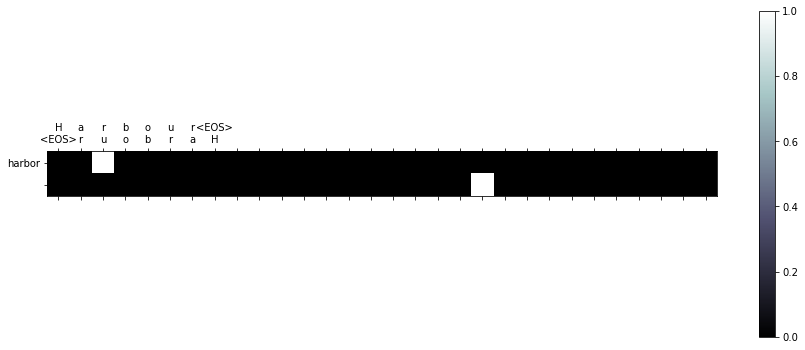

In [186]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    #ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    input_sentence = input_sentence + ['<EOS>']
    inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    ax.set_xticklabels([''] + inp_arr, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    
    sample_row = balanced_data_sample_row()
    #sample_row = balanced_data[balanced_data['before'].str.len()>15].sample(1).iloc[0]
    sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']

    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, 
                                                            return_more=True, sample=sample)
    print('input:  ', sample[0])
    print('output: ', decoded_output)
    print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)

debug_eval_sample_show_attention()

In [ ]:
balanced_data.groupby('class')['class'].unique()

In [ ]:
def test_in_categories(iter_len = 1000):
    wrong_preds = {}
    for cat in categories_all:
        tmp_data = sample_data[sample_data['class'] == cat].sample(iter_len)
        correct_n = 0
        wrong_preds_arr = []

        for _ in range(iter_len):
            sample_row = tmp_data.iloc[_]
            sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']

            output, t1, sample_target, t2 = test_model_single_sample(None, sample=sample)
            if output == sample_target:
                correct_n += 1
            else:
                wrong_preds_arr.append([sample_target, output])

        print("{:>10}: {:>5d}/{:>5d} ({:>4.0%})".format(cat, correct_n, iter_len, correct_n/iter_len))
        wrong_preds[cat] = wrong_preds_arr
    return wrong_preds

In [ ]:
wrong_preds = test_in_categories(3000)

In [ ]:
wrong_preds['LETTERS']

In [ ]:
# With training longer words
wrong_preds = test_in_categories()